# Radiative Transfer Project
**Spring 2017  
Drew Camron and Matt Cann**

## Code, Analysis, and Figures

### Important Reading
[python-hdf4 (aka pyhdf) module docs](http://fhs.github.io/python-hdf4/)  
[sample modis import](http://hdfeos.org/zoo/LAADS/MOD08_D3_Cloud_Fraction_Liquid.py)  
[sample cloudsat import](http://hdfeos.org/zoo/OTHER/2010128055614_21420_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf.py)

### Importing and cleaning data
**Note**: some of the output used to investigate the HDF files has been squashed to save page space, but the code is still valid.

In [1]:
%matplotlib inline
from pyhdf.SD import *
from pyhdf.VS import *
from pyhdf.V import *
from pyhdf.HDF import *
import numpy as np

in_modis = 'Data/aqua-modis_ctpres_20151225_0140.hdf'
in_cs = 'Data/cloudsat_radar_20151225.hdf'

m = SD(in_modis, SDC.READ)
c = SD(in_cs, SDC.READ)

hm = HDF(in_modis)
hc = HDF(in_cs)

These data files are structured differently. The MODIS data stores all of its coordinates and data in datasets, to be viewed and extracted below.

In [2]:
dslat_m = m.select('Latitude')
dslon_m = m.select('Longitude')
dsct_m = m.select('Cloud_Top_Height')

lat_m = dslat_m.get()    # MODIS swath latitude
lon_m = dslon_m.get()    # MODIS swath longitude
# converting to [0,360] deg E longitude
lon_m[lon_m < 0] = lon_m[lon_m < 0] + 360
ct_mi = dsct_m.get()
at = dsct_m.attributes()

Here we can pull in some of the provided attributes. The data are not scaled or offset, but we will make sure to NaN invalid data.

In [3]:
_FillValue = at['_FillValue']
vra = at['valid_range']
ctname_m = at['long_name']
ctunits_m = at['units']

invalid = np.logical_or(ct_mi < vra[0], ct_mi > vra[1], ct_mi == _FillValue)
ct_m = ct_mi.astype(float)    # cleaned MODIS cloud-top height data
ct_m[invalid] = np.nan

Now, the cloudsat data have coordinating information hidden in the HDF vdata, which we will investigate and extract below.

In [4]:
vsc = hc.vstart()

In [5]:
latc = vsc.attach('Latitude')
latc.setfields('Latitude')
n, _, _, _, _ = latc.inquire()
lat_c = np.array(latc.read(n))    # cloudsat path latitudes
latc.detach()

lonc = vsc.attach('Longitude')
lonc.setfields('Longitude')
n, _, _, _, _ = lonc.inquire()
lon_c = np.array(lonc.read(n))    # cloudsat path longitudes
lonc.detach()
# converting to [0,360] deg E longitude
lon_c[lon_c < 0] = lon_c[lon_c < 0] + 360

In [6]:
dshgt_c = c.select('Height')
dsref_c = c.select('Radar_Reflectivity')

hgt_ci = dshgt_c.get()
ref_ci = dsref_c.get()

As the data descriptors are a headache and a half to by-hand pull out of the HDF vgroups, they were inspected manually with HDFVIEW and imported here. Height were unscaled/unoffset, Reflectivity were scaled by 100.

In [7]:
hgtc_name = 'Height of range bin in Reflectivity/Cloud Mask above reference surface (~mean sea level).'
hgtc_units = 'm'

vra = [-5000, 30000]
_FillValue = -9999

invalid = np.logical_or(hgt_ci < vra[0], hgt_ci > vra[1], hgt_ci == _FillValue)
hgt_c = hgt_ci.astype(float)      # cleaned height data
hgt_c[invalid] = np.nan

In [8]:
refc_name = 'Radar Reflectivity Factor'
refc_units = 'dBZe'
refc_scale = 100

vra = [-4000, 5000]
_FillValue = -8192

invalid = np.logical_or(ref_ci < vra[0], ref_ci > vra[1], ref_ci == _FillValue)
ref_c_pre = ref_ci.astype(float)
ref_c_pre[invalid] = np.nan
ref_c = ref_c_pre / refc_scale    # cleaned and scaled cloudsat reflectivity data

Finally, we'll close all of our open files and datasets.

### Now we can do some data analysis!

#### Subsetting and co-locating the data
So, now we need to narrow down the cloudsat granule to our MODIS domain.

In [9]:
nlat_c_mask = np.logical_and(lat_c >= lat_m.min(), lat_c <= lat_m.max())
nlon_c_mask = np.logical_and(lon_c >= lon_m.min(), lon_c <= lon_m.max())
nref_c_mask = np.logical_and(
    nlat_c_mask.flatten() == True, nlon_c_mask.flatten() == True)

nlat_c = lat_c[nref_c_mask]
nlon_c = lon_c[nref_c_mask]
nref_c = ref_c[nref_c_mask]

Now that we have Cloudsat narrowed down to at least the rough MODIS domain, we will attempt to select all of the nearest points to the Cloudsat orbit track. First, we re-created the initial MODIS plot to include the subset Cloudsat track overlayed, to make sure our domains were lining up correctly.

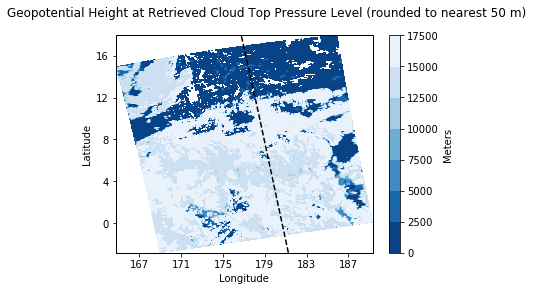

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.set_xticks(np.arange(163, 192, 4))
ax.set_yticks(np.arange(-4, 21, 4))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.suptitle(ctname_m)
c = plt.contourf(lon_m, lat_m, ct_m, cmap='Blues_r', transform=ccrs.Mercator())
cb = plt.colorbar(c)
cb.set_label('Meters')
ax2 = plt.axes(projection=ccrs.Mercator())
cs = plt.plot(nlon_c, nlat_c, 'k--')
fig.savefig('figures/modis_cloud-top-height.png')

And we can re-create our initial Cloudsat profile to actually line up with our MODIS domain.

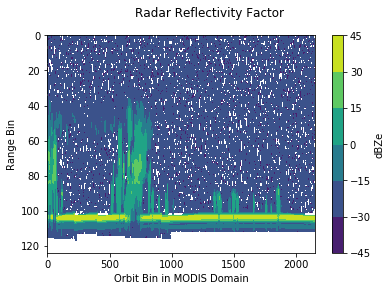

In [11]:
fig = plt.figure()
fig.suptitle(refc_name)
ax = plt.axes()
c = plt.contourf(nref_c.T)
ax.invert_yaxis()
ax.set_ylabel('Range Bin')
ax.set_xlabel('Orbit Bin in MODIS Domain')
cb = plt.colorbar()
cb.set_label(refc_units)
fig.savefig('figures/cloudsat_radar-reflectivity.png')

Now we will attempt to loop through Cloudsat and find the minimum-distance lat/lon pairs from the MODIS data.

In [44]:
for i in range(len(nref_c[:, 0])):
    

IndentationError: expected an indented block (<ipython-input-44-81971bdd5951>, line 2)